In [2]:
# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns

# Imports

## Librairies

In [45]:
import numpy as np
import pandas as pd
import os
import warnings
import time
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import shap

import mlflow
import mlflow.sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif

## Options

In [2]:
sns.set()
warnings.filterwarnings('ignore')

# pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
pd.set_option('display.max_colwidth', None)

logging.getLogger("mlflow").setLevel(logging.ERROR)

## Data

In [4]:
df = pd.read_csv('../data/cleaned/df.csv', sep=";")
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,False,False,False,False,False,True,False,True,False,False
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,True,False,False,False,False,False,False,True,False,False
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,False,False,False,False,False,False
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,False,False,False,False,False,False
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,False,False,False,False,False,False


In [5]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 244 columns):
 #    Column                                             Non-Null Count   Dtype  
---   ------                                             --------------   -----  
 0    SK_ID_CURR                                         307511 non-null  int64  
 1    TARGET                                             307511 non-null  int64  
 2    NAME_CONTRACT_TYPE                                 307511 non-null  int64  
 3    FLAG_OWN_CAR                                       307511 non-null  int64  
 4    FLAG_OWN_REALTY                                    307511 non-null  int64  
 5    CNT_CHILDREN                                       307511 non-null  int64  
 6    AMT_INCOME_TOTAL                                   307511 non-null  float64
 7    AMT_CREDIT                                         307511 non-null  float64
 8    AMT_ANNUITY                                        307499 non-

# MLFlow

## Régression Logistique

### Préparation des données

In [6]:
if 'TARGET' in df.columns:
    X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
    y = df['TARGET']
else:
    X = df.drop(columns=['SK_ID_CURR']).copy()

feature_names = X.columns
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0, 1))

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)
print(f"Shape du dataset prétraité : {X_scaled.shape}")

Shape du dataset prétraité : (307511, 242)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train shape : {X_train.shape}")
print(f"Test shape : {X_test.shape}")

Train shape : (246008, 242)
Test shape : (61503, 242)


### Baseline

In [8]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Regression Logistique Baseline")

with mlflow.start_run(run_name="RL Baseline") as run:
    # Paramètres du modèle
    C_value = 0.0001

    # Entraînement du modèle
    log_reg = LogisticRegression(C=C_value, class_weight="balanced")
    log_reg.fit(X_train, y_train)

    # PRédictions
    preds = log_reg.predict(X_test)

    # Calcul des métriques
    acc = accuracy_score(y_test, preds)
    try:
        auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
    except Exception as e:
        auc = None

    print(f"Accuracy : {acc}")
    print(f"ROC AUC : {auc}")

    # Enregistrement des paramètres et métriques dans MLFlow
    mlflow.log_param("C", C_value)
    mlflow.log_param("imputer_strategy", "median")
    mlflow.log_param("scaler_range", (0, 1))
    mlflow.log_metric("accuracy", acc)

    if auc is not None:
        mlflow.log_metric("roc_auc", auc)

    # Enregistrement du modèle dans MLFlow
    mlflow.sklearn.log_model(log_reg, "model", input_example=X_test[0:1])

Accuracy : 0.6521145309984879
ROC AUC : 0.7140444250935936


🏃 View run RL Baseline at: http://127.0.0.1:5000/#/experiments/1/runs/11f58fd10efe472ca774984a4b17537d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


## Fonction de coût

In [9]:
def custom_cost_function(y_true, y_pred, cost_false_positive=1, cost_false_negative=3):
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_pred).ravel()
    cost = cost_false_positive * false_positive + cost_false_negative * false_negative
    return cost

In [10]:
cost_scorer = make_scorer(
    custom_cost_function,
    greater_is_better=False,
    cost_false_positive = 1,
    cost_false_negative = 10
)

### Hyperparmètres

In [11]:
param_grid = {
    "C" : [0.0001, 0.001, 0.1, 1, 10]
}

log_reg = LogisticRegression(class_weight="balanced")

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring=cost_scorer,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"Coût minimum obtenu : {grid_search.best_score_}")

Meilleurs hyperparamètres : {'C': 10}
Coût minimum obtenu : -27114.0


In [12]:
best_cost = -grid_search.best_score_
print("Coût minimum réel :", best_cost)

Coût minimum réel : 27114.0


### Modèle avec fonction coût

In [13]:
# mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.set_experiment("Regression_Logistique_Score_Metier")

# with mlflow.start_run():
#     # Paramètres du modèle
#     grid_search.fit(X_train, y_train)

#     # Récupérer les résultats
#     best_cost_cv = -grid_search.best_score_
#     best_params = grid_search.best_params_
#     best_model = grid_search.best_estimator_
    
#     # Évalutation sur test
#     y_pred_test = best_model.predict(X_test)
#     true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_test, y_pred_test).ravel()
#     test_cost = 1 * false_positive + 3 * false_negative

#     # Calcul des métriques
#     acc_test = accuracy_score(y_test, y_pred_test)
#     auc_test = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

#     # Enregistrement des paramètres et métriques dans MLFlow
#     mlflow.log_params(best_params)
#     mlflow.log_param("cost_cv", best_cost_cv)
#     mlflow.log_param("cost_test", test_cost)
#     mlflow.log_param("accuracy_test", acc_test)
#     mlflow.log_param("auc_test", auc_test)

#     # Enregistrement du modèle dans MLFlow
#     mlflow.sklearn.log_model(best_model, "model", input_example=X_test[0:1])

In [14]:
def train_model(X_train, y_train, param_grid, cost_scorer):
    log_reg = LogisticRegression(class_weight="balanced", max_iter=1000)

    grid_search = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid,
        scoring=cost_scorer,
        cv=5,
        n_jobs=-1
    )
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()

    train_time = end_time - start_time
    print(f"Temps d'entraînement (GridSearchCV) : {train_time:.2f} secondes.")
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cost_cv = -grid_search.best_score_
    
    return best_model, best_params, best_cost_cv, train_time

In [15]:
def evaluate_and_log_model(best_model, best_params, best_cost_cv, X_test, y_test, train_time,
                           experiment_name="Regression_Logistique_Score_Metier",
                           cost_fp=1, cost_fn=10, run_name=""):
    
    # Configuration de MLFlow
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.set_experiment(experiment_name)

    # Évalutation sur test
    y_pred_test = best_model.predict(X_test)
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_test, y_pred_test).ravel()
    test_cost = cost_fp * false_positive + cost_fn * false_negative

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

    with mlflow.start_run(run_name=run_name):
        # Enregistrement des paramètres et métriques dans MLFlow
        mlflow.log_params(best_params)
        mlflow.log_param("cost_cv", best_cost_cv)
        mlflow.log_param("cost_test", test_cost)
        mlflow.log_param("accuracy_test", acc_test)
        mlflow.log_param("auc_test", auc_test)
        mlflow.log_metric("training_time", train_time)
    
        # Enregistrement du modèle dans MLFlow
        mlflow.sklearn.log_model(best_model, "model", input_example=X_test[0:1])

        df_eval = pd.DataFrame({
            "Model" : [str(best_model.__class__.__name__)],
            "Hyperparams" : [str(best_params)],
            "Cost_cv" : [best_cost_cv],
            "Cost_test" : [test_cost],
            "Accuracy_test" : [acc_test],
            "AUC_test" : [auc_test],
            "Training_time" : [train_time],
            "Cost_fp" : [cost_fp],
            "Cost_fn" : [cost_fn],
            "Experiment_name" : [experiment_name],
        })

        return df_eval

In [16]:
best_model, best_params, best_cost_cv, train_time = train_model(X_train, y_train, 
                                                    param_grid={"C": [0.0001, 0.001, 0.1, 1]},
                                                    cost_scorer=cost_scorer)

Temps d'entraînement (GridSearchCV) : 278.82 secondes.


In [17]:
df_reg_log = evaluate_and_log_model(
    best_model, best_params, best_cost_cv,
    X_test, y_test, train_time,
    experiment_name="Regression Logistique (1:10)",
    run_name="RL (1:10)"
)

df_reg_log

🏃 View run RL (1:10) at: http://127.0.0.1:5000/#/experiments/2/runs/e3b4cac79c4f4a0b90585d1652edb99c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


,Model,Hyperparams,Cost_cv,Cost_test,Accuracy_test,AUC_test,Training_time,Cost_fp,Cost_fn,Experiment_name
0,LogisticRegression,{'C': 1},26984.4,33505,0.690243,0.748756,278.824975,1,10,Regression Logistique (1:10)


### Coefficients

In [18]:
# Récupération des coefficients (on utilise flatten car c'est un tableau 2D)
coeffs = best_model.coef_.flatten()

coeffs_df = pd.DataFrame({
    'feature' : feature_names,
    'coefficient' : coeffs 
})

coeffs_df = coeffs_df.sort_values('coefficient', ascending=False)
coeffs_df.head(10)

,feature,coefficient
5,AMT_CREDIT,7.555668
79,DEF_60_CNT_SOCIAL_CIRCLE,2.789027
77,DEF_30_CNT_SOCIAL_CIRCLE,2.701623
81,FLAG_DOCUMENT_2,2.321939
6,AMT_ANNUITY,2.058352
59,NONLIVINGAPARTMENTS_MODE,1.693999
44,LIVINGAREA_AVG,1.414237
62,BASEMENTAREA_MEDI,1.313353
71,LIVINGAPARTMENTS_MEDI,1.269710
10,DAYS_EMPLOYED,1.183135


In [19]:
coeffs_df.tail(10)

,feature,coefficient
122,NAME_INCOME_TYPE_Student,-1.118920
96,FLAG_DOCUMENT_17,-1.129196
125,NAME_EDUCATION_TYPE_Academic degree,-1.183872
30,EXT_SOURCE_1,-1.218633
34,BASEMENTAREA_AVG,-1.369527
83,FLAG_DOCUMENT_4,-1.391308
31,EXT_SOURCE_2,-1.745591
32,EXT_SOURCE_3,-2.438446
105,AMT_REQ_CREDIT_BUREAU_QRT,-4.380721
7,AMT_GOODS_PRICE,-8.842958


### Matrice de confusion

In [20]:
y_pred_test = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print(f"Matrice de confusion (test) : \n {cm}")
print("\n")
print(f"Vrais négatifs : {tn}\nFaux positifs : {fp}\nFaux négatifs : {fn} \nVrais positifs : {tp}")

Matrice de confusion (test) : 
 [[39093 17445]
 [ 1606  3359]]


Vrais négatifs : 39093
Faux positifs : 17445
Faux négatifs : 1606 
Vrais positifs : 3359


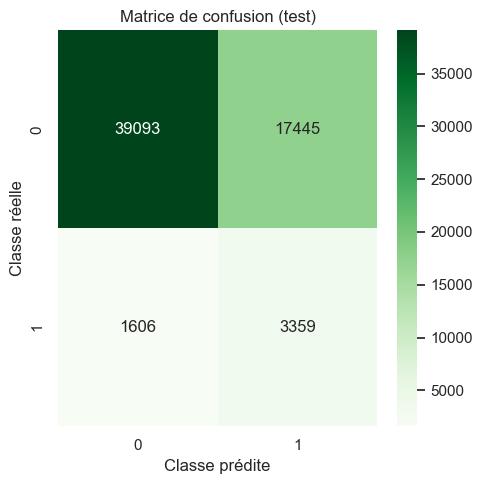

In [21]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")

plt.title("Matrice de confusion (test)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

plt.tight_layout()
plt.show()

## DummyClassifier

In [23]:
def dummy_classifier(X_train, y_train, X_test, y_test, cv=5):
    
    dummy = DummyClassifier(strategy="most_frequent")

    start_time = time.time()
    y_pred_cv = cross_val_predict(dummy, X_train, y_train, cv=cv, n_jobs=-1)
    end_time = time.time()
    train_time = end_time - start_time

    dummy.fit(X_train, y_train)
    y_pred_test = dummy.predict(X_test)

    try:
        y_proba_test = dummy.predict_proba(X_test)[:, 1]
        auc_test = roc_auc_score(y_test, y_proba_test)
    except:
        auc_test = None
        
    accuracy_test = accuracy_score(y_test, y_pred_test)

    cost_cv = custom_cost_function(y_train, y_pred_cv,
                                  cost_false_positive=1,
                                  cost_false_negative=10)

    cost_test = custom_cost_function(y_test, y_pred_test,
                                    cost_false_positive=1,
                                    cost_false_negative=10)

    row = {
        "Model" : "DummyClassifier",
        "Hyperparams" : f"cross_val_predict(cv={cv})",
        "Cost_cv" : best_cost_cv,
        "Cost_test" : cost_test,
        "Accuracy_test" : accuracy_test,
        "AUC_test" : auc_test,
        "Training_time" : train_time,
        "Cost_fp" : 1,
        "Cost_fn" : 10,
        "Experiment_name" : "DummyClassifier (1:10)"
    }
        

    df_dummy = pd.DataFrame([row])

    return df_dummy

In [24]:
df_dummy = dummy_classifier(X_train, y_train, X_test, y_test, cv=5)
df_dummy

,Model,Hyperparams,Cost_cv,Cost_test,Accuracy_test,AUC_test,Training_time,Cost_fp,Cost_fn,Experiment_name
0,DummyClassifier,cross_val_predict(cv=5),26984.4,49650,0.919272,0.5,3.464551,1,10,DummyClassifier (1:10)


# MATRICE DE CONFUSION DUMMY

In [25]:
cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
print(cm)

[[39093 17445]
 [ 1606  3359]]


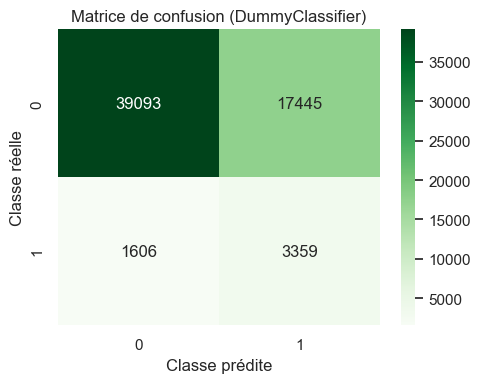

In [26]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")

plt.title("Matrice de confusion (DummyClassifier)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

plt.tight_layout()
plt.show()

## RandomForestClassifier

In [29]:
param_grid_rf = {
    "n_estimators": [50, 100],
    "max_depth": [1, 5, 10],
    "min_samples_split": [2, 3]
}

In [30]:
def train_random_forest(X_train, y_train, param_grid_rf, cost_scorer):
    random_forest_classifier = RandomForestClassifier(class_weight="balanced", random_state=42)

    grid_search_rf = GridSearchCV(
    estimator=random_forest_classifier,
    param_grid=param_grid_rf,
    scoring=cost_scorer,
    cv=5,
    n_jobs=-1
    )

    start_time = time.time()
    grid_search_rf.fit(X_train, y_train)
    end_time = time.time()
    train_time_rf = end_time - start_time

    best_model_rf = grid_search_rf.best_estimator_
    best_params_rf = grid_search_rf.best_params_
    best_cost_cv_rf = -grid_search_rf.best_score_

    return best_model_rf, best_params_rf, best_cost_cv_rf, train_time_rf

In [31]:
best_model_rf, best_params_rf, best_cost_cv_rf, train_time_rf = train_random_forest(
    X_train, y_train, param_grid_rf, cost_scorer
)

In [36]:
df_rf = evaluate_and_log_model(
    best_model=best_model_rf,
    best_params=best_params_rf,
    best_cost_cv=best_cost_cv_rf,
    X_test=X_test,
    y_test=y_test,
    train_time=train_time_rf,
    experiment_name="Random Forest Classifier (1:10)",
    cost_fp=1,
    cost_fn=10,
    run_name="RF (1:10)"
)

🏃 View run RF (1:10) at: http://127.0.0.1:5000/#/experiments/3/runs/d537baa10f2140b0bf064f3c426dfd04
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


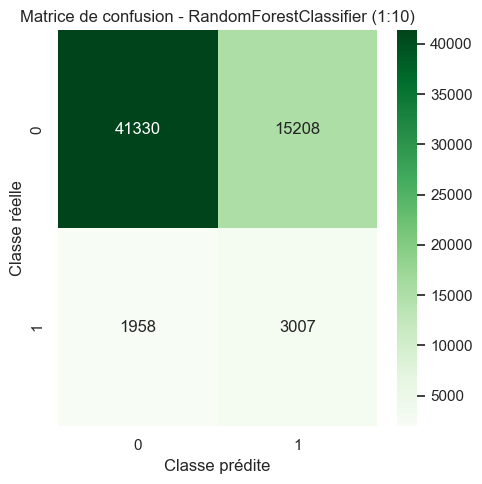

In [37]:
y_pred_test_rf = best_model_rf.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred_test_rf, labels=[0, 1])
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

plt.figure(figsize=(5, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")

plt.title("Matrice de confusion - RandomForestClassifier (1:10)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

plt.tight_layout()
plt.show()

In [38]:
df_results = pd.concat([
    df_dummy,
    df_reg_log,
    df_rf
], ignore_index=True)

df_results

,Model,Hyperparams,Cost_cv,Cost_test,Accuracy_test,AUC_test,Training_time,Cost_fp,Cost_fn,Experiment_name
0,DummyClassifier,cross_val_predict(cv=5),26984.4,49650,0.919272,0.500000,3.464551,1,10,DummyClassifier (1:10)
1,LogisticRegression,{'C': 1},26984.4,33505,0.690243,0.748756,278.824975,1,10,Regression Logistique (1:10)
2,RandomForestClassifier,"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}",28166.4,34788,0.720892,0.730433,454.999622,1,10,Random Forest Classifier (1:10)


### Feature importance

#### Globale

In [57]:
coeffs_rl = best_model.coef_.flatten()

coeffs_rl_df = pd.DataFrame({
    'feature' : feature_names,
    'coefficient' : coeffs,
    'abs_coefficient' : np.abs(coeffs)
}).sort_values(by='abs_coefficient', ascending=False)

coeffs_rl_df.head(50)

,feature,coefficient,abs_coefficient
7,AMT_GOODS_PRICE,-8.842958,8.842958
5,AMT_CREDIT,7.555668,7.555668
105,AMT_REQ_CREDIT_BUREAU_QRT,-4.380721,4.380721
79,DEF_60_CNT_SOCIAL_CIRCLE,2.789027,2.789027
77,DEF_30_CNT_SOCIAL_CIRCLE,2.701623,2.701623
32,EXT_SOURCE_3,-2.438446,2.438446
81,FLAG_DOCUMENT_2,2.321939,2.321939
6,AMT_ANNUITY,2.058352,2.058352
31,EXT_SOURCE_2,-1.745591,1.745591
59,NONLIVINGAPARTMENTS_MODE,1.693999,1.693999


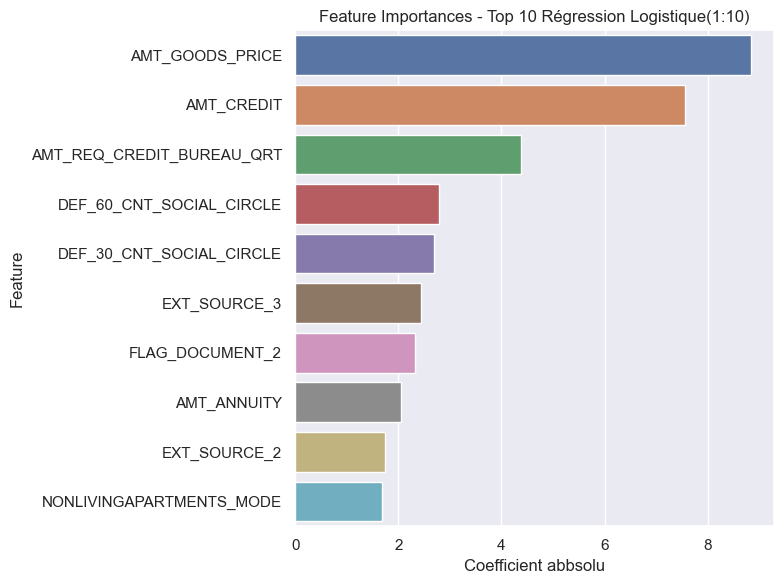

In [58]:
plt.figure(figsize=(8, 6))

sns.barplot(x="abs_coefficient", y="feature", data=coeffs_rl_df.head(10))
plt.title("Feature Importances - Top 10 Régression Logistique(1:10)")
plt.xlabel("Coefficient abbsolu")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

In [59]:
# Récupération des importances
importances = best_model_rf.feature_importances_

# Récupération des noms de colonnes
features_names = df.drop(columns=["TARGET"]).columns

# Construction du df
df_importances = pd.DataFrame({
    'feature' : feature_names,
    'importance': importances
})

# Tri par ordre décroissant
df_importances = df_importances.sort_values('importance', ascending=False)
df_importances.head(10)

,feature,importance
32,EXT_SOURCE_3,0.161608
31,EXT_SOURCE_2,0.158830
30,EXT_SOURCE_1,0.055398
10,DAYS_EMPLOYED,0.041900
9,DAYS_BIRTH,0.030800
7,AMT_GOODS_PRICE,0.024908
80,DAYS_LAST_PHONE_CHANGE,0.023112
5,AMT_CREDIT,0.020045
126,NAME_EDUCATION_TYPE_Higher education,0.017849
12,DAYS_ID_PUBLISH,0.017525


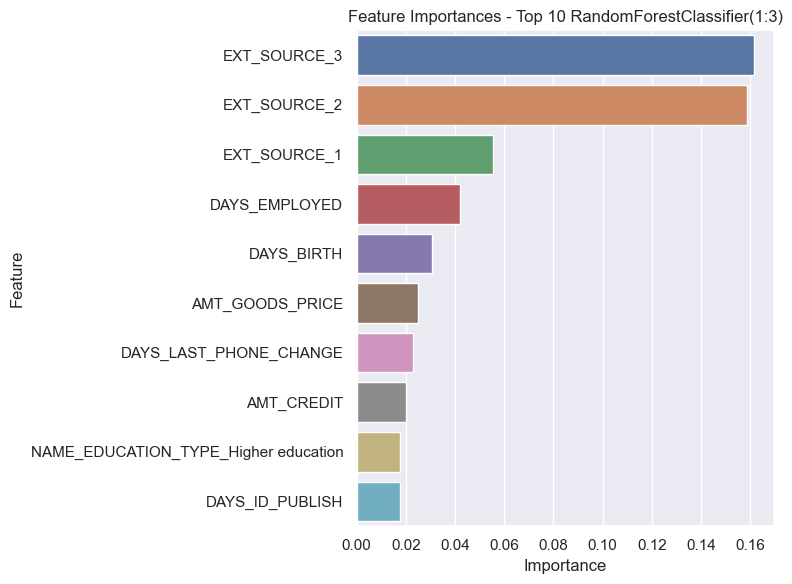

In [60]:
plt.figure(figsize=(8, 6))

sns.barplot(x="importance", y="feature", data=df_importances.head(10))
plt.title("Feature Importances - Top 10 RandomForestClassifier(1:3)")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

#### Locale

In [42]:
X_test_df = pd.DataFrame(X_test, columns=feature_names)
X_sample_df = X_test_df.sample(n=500, random_state=42)

In [43]:
X_test_df

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,0.0,1.0,1.0,0.052632,0.001127,0.181097,0.113338,0.161616,0.136490,0.339177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000550,0.079874,0.071411,0.068462,0.097483,0.576888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.000000,0.001050,0.059775,0.066409,0.046016,0.196267,0.941995,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.001389,0.232637,0.142752,0.207632,0.282797,0.121815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.000000,0.001320,0.069462,0.070376,0.059484,0.491595,0.563585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,0.0,0.0,1.0,0.000000,0.001166,0.197016,0.101702,0.169473,0.309272,0.756313,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
61499,0.0,1.0,1.0,0.000000,0.001320,0.314607,0.142506,0.315376,0.257000,0.580665,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
61500,0.0,1.0,1.0,0.052632,0.002858,0.048652,0.099228,0.046016,0.138276,0.331454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
61501,0.0,1.0,1.0,0.000000,0.002666,0.213483,0.172920,0.214366,0.129331,0.218433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


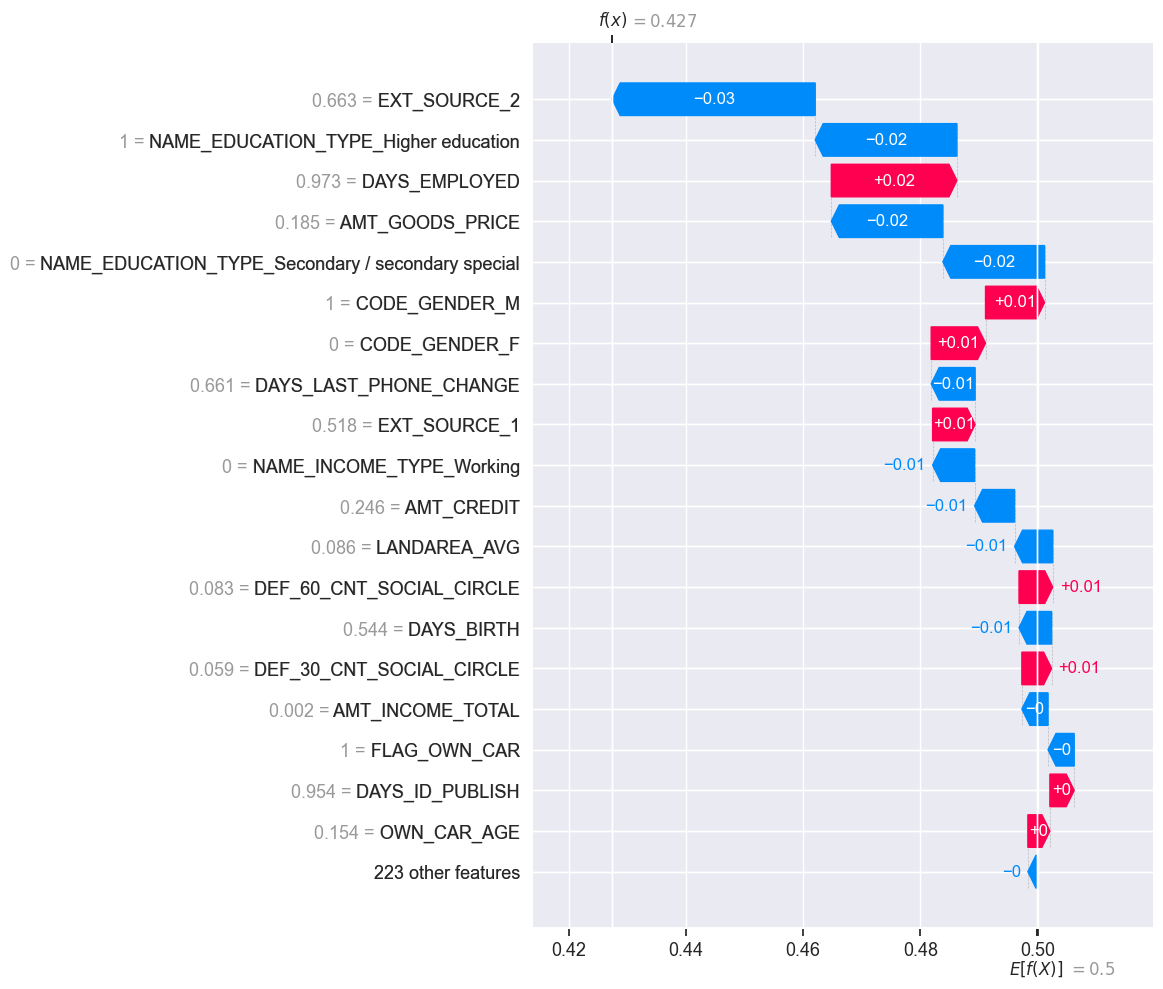

In [44]:
explainer = shap.TreeExplainer(best_model_rf)
shap_values = explainer.shap_values(X_sample_df)

# Choix d'un individu
i = 0

# Valeurs SHAP de la classe 1
shap_values_class_1 = shap_values[:, :, 1]

# Base value pour la classe 1 (valeur de base = expected_value)
base_value_class_1 = explainer.expected_value[1]

# Constrution de l'objet Explanation pour la classe 1 et l'individu 1
shap_values_i = shap_values_class_1[i, :]

explanation = shap.Explanation(
    values=shap_values_i, # Valeurs SHAP de l'individu 1
    base_values=base_value_class_1, # Valeur de base (moyenne log-odds ou prob)
    data=X_sample_df.iloc[i, :], # Les features de l'individu 1
    feature_names=X_sample_df.columns # Noms des colonnes pour le plot
)

# Génération du waterplot
shap.initjs()
shap.plots.waterfall(explanation, max_display=20)

Le but d'une feature importance locale est de montrer, pour un individu précis, comment chaque feature fait varier la prédiction par rapport à la valeur de base.

- Les barres bleues (négatives) réduisent la probabilité de classe 1
- Les barre roses (positives) l'augmentent
- Plus la variable est vers le haut au niveau du graphique, plus l'impact est fort pour cet individu

In [61]:
top50_features = coeffs_rl_df.head(50)['feature'].tolist()

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

X_train_top50 = X_train_df[top50_features].values
X_test_top50 = X_test_df[top50_features].values

In [63]:
model_rl_50, params_rl_50, cost_cv_rl_50, train_time_rl_50 = train_model(
    X_train_top50, y_train,
    param_grid={"C" : [0.0001, 0.001, 0.1, 1]},
    cost_scorer=cost_scorer
)

Temps d'entraînement (GridSearchCV) : 47.32 secondes.


In [65]:
df_rl_50 = evaluate_and_log_model(
    model_rl_50,
    params_rl_50,
    cost_cv_rl_50,
    X_test_top50,
    y_test,
    train_time_rl_50,
    experiment_name="Regression Logistique (1:10) - top 50 features",
    run_name="RL top 50 features"
)

df_rl_50

🏃 View run RL top 50 features at: http://127.0.0.1:5000/#/experiments/4/runs/5a6b83fcd1c34677b038591963fd4816
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4


,Model,Hyperparams,Cost_cv,Cost_test,Accuracy_test,AUC_test,Training_time,Cost_fp,Cost_fn,Experiment_name
0,LogisticRegression,{'C': 1},27881.0,34791,0.681186,0.733442,47.320624,1,10,Regression Logistique (1:10) - top 50 features


In [68]:
model_rf_50, params_rf_50, cost_cv_rf_50, train_time_rf_50 = train_random_forest(
    X_train_top50, y_train,
    param_grid_rf,
    cost_scorer
)

In [69]:
df_rf_50 = evaluate_and_log_model(
    model_rf_50,
    params_rf_50,
    cost_cv_rf_50,
    X_test_top50,
    y_test,
    train_time_rf_50,
    experiment_name="RandomForestClassifier (1:10) - top 50 features",
    run_name="RF top 50 features"
)

df_rf_50

🏃 View run RF top 50 features at: http://127.0.0.1:5000/#/experiments/5/runs/eb0120d46f2643739a4c5cf353b4e5a1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5


,Model,Hyperparams,Cost_cv,Cost_test,Accuracy_test,AUC_test,Training_time,Cost_fp,Cost_fn,Experiment_name
0,RandomForestClassifier,"{'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 50}",28029.2,34689,0.714599,0.731538,290.027885,1,10,RandomForestClassifier (1:10) - top 50 features


In [70]:
df_results = pd.concat([
    df_dummy,
    df_reg_log,
    df_rl_50,
    df_rf,
    df_rf_50,
], ignore_index=True)

df_results

,Model,Hyperparams,Cost_cv,Cost_test,Accuracy_test,AUC_test,Training_time,Cost_fp,Cost_fn,Experiment_name
0,DummyClassifier,cross_val_predict(cv=5),26984.4,49650,0.919272,0.500000,3.464551,1,10,DummyClassifier (1:10)
1,LogisticRegression,{'C': 1},26984.4,33505,0.690243,0.748756,278.824975,1,10,Regression Logistique (1:10)
2,LogisticRegression,{'C': 1},27881.0,34791,0.681186,0.733442,47.320624,1,10,Regression Logistique (1:10) - top 50 features
3,RandomForestClassifier,"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}",28166.4,34788,0.720892,0.730433,454.999622,1,10,Random Forest Classifier (1:10)
4,RandomForestClassifier,"{'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 50}",28029.2,34689,0.714599,0.731538,290.027885,1,10,RandomForestClassifier (1:10) - top 50 features
